In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [174]:
# load scaped dataset and display the first 5 rows.

data = pd.read_csv('D:/Downloads/Omaha.csv')
data.head()

,address,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_parking,num_garage,lot_size,home_type,roof,year_built,year_remodel,school_rating,latitude,longitude,prices
0,"6035 Lafayette Ave, Omaha, NE 68132",https://www.zillow.com/homedetails/6035-Lafaye...,3.0,2.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1490.0,1.0,1.0,0.25,Single Family,Composition,1955.0,NaN,2,41.271194,-96.006736,170000
1,"13311 Slayton St, Omaha, NE 68138",https://www.zillow.com/homedetails/13311-Slayt...,3.0,3.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1668.0,2.0,2.0,8973.00,Single Family,Composition,1973.0,NaN,7,41.140034,-96.121963,215000
2,"5808 S 239th St, Elkhorn, NE 68022",https://www.zillow.com/homedetails/5808-S-239t...,5.0,6.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,4801.0,3.0,3.0,0.31,Single Family,Composition,2015.0,NaN,8,41.198498,-96.290756,675000
3,"3021 S 94th St, Omaha, NE 68124",https://www.zillow.com/homedetails/3021-S-94th...,3.0,3.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1976.0,2.0,2.0,10018.00,Single Family,Composition,1964.0,NaN,8,41.231110,-96.059982,196500
4,"111 S 51st St, Omaha, NE 68132",https://www.zillow.com/homedetails/111-S-51st-...,3.0,3.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1898.0,2.0,2.0,6534.00,Single Family,Composition,1921.0,NaN,5,41.258778,-95.992301,265000


In [175]:
data.shape

(2895, 19)

In [176]:
# Check the missing value.

data.isnull().sum()

address             0
links               0
num_bedroom       305
num_bathroom      395
basement         1123
heating           432
cooling          1909
livable_area      307
num_parking      1697
num_garage        662
lot_size          699
home_type         301
roof              484
year_built        375
year_remodel     2438
school_rating      27
latitude           28
longitude          28
prices              0
dtype: int64

In [177]:
df_subset = data[data['num_parking'].notna()]
(df_subset.num_parking==df_subset.num_garage).sum()

1198

In [178]:
# All the data in num_parking equal to the data in num_garage, so I can only keep one of them.

df_subset.shape

(1198, 19)

In [179]:
# I drop the column num_paking, year-remodel, most of year-remodel are missing, and remove some columns which I will not use

data.drop(columns=['num_parking', 'year_remodel', 'latitude', 'longitude'], inplace=True)

In [180]:
# Fix missing value in num_garage.

data['num_garage'] = data['num_garage'].fillna(round(data['num_garage'].median()))

In [181]:
# Fix missing value in num_bedroom.

data['num_bedroom'] = data['num_bedroom'].fillna(round(data['num_bedroom'].median()))

In [182]:
# Fix missing value in num_bathroom.

data['num_bathroom'] = data['num_bathroom'].fillna(round(data['num_bathroom'].median()))

In [183]:
data.basement.value_counts()

Finished                                 557
Partially finished                       499
Yes                                      427
Unfinished                               156
None                                      69
Full                                      19
Fully Finished, Daylight                  15
Fully Finished                             8
Partial                                    7
Daylight                                   5
Basement (not specified)                   2
Partial Finished                           1
PARTIAL, CRAWL SPACE, PARTLY FINISHED      1
Crawl                                      1
Pour                                       1
Slab                                       1
Partially Finished                         1
Living Room                                1
Finished (Livable)                         1
Name: basement, dtype: int64

In [184]:
# Fix the value in basement

def basement_conversion(desc):
    if str(desc)=='nan':
        return 'Basement (not specified)'
    elif desc.strip() in ['Yes', 'Daylight', 'Full', 'Fully Finished, Daylight', 'Fully Finished', 'Finished (Livable)', 'Living Room', 'Slab']:
        return 'Finished'
    elif desc.strip() in ['Partial', 'Partially finished', 'Partially Finished', 'PARTIAL, CRAWL SPACE, PARTLY FINISHED', 'Partial Finished','Crawl', 'Pour']:
        return 'Partially Finished '
    else:
        return desc

In [185]:
# Apply the function.

data.basement = data.basement.apply(basement_conversion)

In [186]:
data.basement.value_counts()

Basement (not specified)    1125
Finished                    1034
Partially Finished           511
Unfinished                   156
None                          69
Name: basement, dtype: int64

In [187]:
data.heating.unique()

array(["['Heating features', 'Forced air, Gas']",
       "['Heating features', 'Gas, Forced air']",
       "['Heating features', 'Forced air, Heat pump, Gas']",
       "['Heating features', 'Gas, Forced air, Other']",
       "['Heating features', 'Radiant, Gas, Forced air']",
       "['Heating features', 'Gas, Other']",
       "['Heating features', 'Baseboard, Gas']",
       "['Heating features', 'Other, Electric']",
       "['Heating features', 'Heat pump, Gas']",
       "['Heating features', 'Other']",
       "['Heating features', 'Forced air, Electric']",
       "['Heating features', 'Forced air, Heat pump, Electric']",
       "['Heating features', 'Electric, Forced air']",
       "['Heating features', 'Heat pump, Propane / Butane']",
       "['Heating features', 'Heat pump, Other, Other']",
       "['Heating features', 'Forced air, Heat pump, Electric, Gas']",
       "['Heating features', 'Gas, Wood / pellet, Forced air']",
       "['Heating features', 'Heat pump, Gas, Forced air']

In [188]:
# Fix the value in heating

def heating_conversion(desc):
    if str(desc)=='nan':
        return 'Gas'
    elif 'gas' in desc.lower():
        if 'electric' in desc.lower():
            return 'Both'
        else:
            return 'Gas'
    elif 'electric' in desc.lower():
        return 'Electric'
    else:
        return 'Other'

In [189]:
# Apply the function.

data.heating = data.heating.apply(heating_conversion)

In [190]:
data.heating.value_counts()

Gas         2183
Other        480
Electric     174
Both          58
Name: heating, dtype: int64

In [191]:
data.cooling.value_counts()

Central Air                      863
Central Air, Zoned                32
Central Air, Heat Pump            24
Window AC                         23
Heat Pump                         16
Central Air, Window AC            10
Other                              9
Central Air, Other                 4
Central Air, Heat Pump, Other      2
Window Ac                          1
Central Air, Zoned, Other          1
Zoned                              1
Name: cooling, dtype: int64

In [192]:
# Fix the value in cooling

def cooling_conversion(desc):
    if str(desc)=='nan':
        return 'Central Air'
    elif 'central air' in desc.lower():
        return 'Central Air'
    elif 'zoned' in desc.lower():
        return 'Central Air'
    elif 'window ac' in desc.lower():
        return 'Window AC'
    else:
         return desc

In [193]:
# Apply the function.

data.cooling = data.cooling.apply(cooling_conversion)

In [194]:
data.cooling.value_counts()

Central Air    2846
Window AC        24
Heat Pump        16
Other             9
Name: cooling, dtype: int64

In [195]:
# Fix missing value in livable_area.

data['livable_area'] = data['livable_area'].fillna(round(data['livable_area'].median()))

In [196]:
# Fix missing value in lot_size.

data['lot_size'] = data['lot_size'].fillna(data['lot_size'].median())

In [197]:
# Function to fix value in home_type.

def home_type_selection(x):
    if str(x)=='nan':
        return 'Single Family'
    elif 'Multiple Occupancy' in x:
        return 'DEL'
    elif 'Mobile / Manufactured' in x:
        return 'DEL'
    elif 'Mobile / Manufactured' in x:
        return 'DEL'
    elif 'Apartment' in x or 'Other' in x:
        return 'DEL'
    else:
        return x

In [198]:
data.home_type = data.home_type.apply(home_type_selection)

In [199]:
home_drop_index = data[data.home_type=='DEL'].index

In [200]:
data.drop(index=home_drop_index, inplace=True)
data.home_type.value_counts()

Single Family    2402
Condo             393
Townhouse          59
Name: home_type, dtype: int64

In [201]:
data.roof.value_counts()

Composition                      1152
Asphalt Shingle                   416
Asphalt                           381
Other                             149
Metal                              45
Flat                               38
Rubber                             35
Shake/Shingle                      24
Shake / Shingle                    22
Tile                               19
Built up                           11
Built-up                           10
Torch Down                          9
Flat, Torch Down                    8
Slate                               6
Shake Shingles                      5
Composition, Flat                   3
Membrane                            3
Roll Roofing                        3
Cedar Shake                         3
Wood Shingle                        2
Composition, Metal                  2
See Remarks                         2
Flat, Built-Up                      2
Flat, Torch Down, Metal             2
See Remarks, Tile                   2
Asphalt Shin

In [202]:
# Function to fix value in roof.

def roof_conversion(desc):
    if str(desc)=='nan':
        return 'Roof(not specified)'
    elif 'composition' in desc.lower():
        return 'Composition'
    elif 'comp' in desc.lower():
        return 'Composition'
    elif 'asphalt shingle' in desc.lower():
        return 'Asphalt Shingle'
    elif 'metal' in desc.lower():
        return 'Metal'
    elif 'asphalt' in desc.lower():
        return 'Asphalt'
    elif 'shingle' in desc.lower():
        return 'Shingle'
    elif 'flat' in desc.lower():
        return 'Flat'
    elif 'tile' in desc.lower():
        return 'Tile'
    elif 'rubber' in desc.lower():
        return 'Rubber'
    else:
        return 'Other'

In [203]:
# Apply the function.

data.roof = data.roof.apply(roof_conversion)

In [204]:
data.roof.value_counts()

Composition            1163
Roof(not specified)     482
Asphalt Shingle         418
Asphalt                 381
Other                   199
Shingle                  55
Metal                    50
Flat                     50
Rubber                   35
Tile                     21
Name: roof, dtype: int64

In [205]:
# Fix missing value in year_built.

data['year_built'] = data['year_built'].fillna(round(data['year_built'].median()))

In [206]:
data.reset_index(drop=True, inplace=True)

In [207]:
del_school_type_idx = data[data.school_rating.apply(lambda x : str(x).startswith('Sc'))].index

In [208]:
data.iloc[del_school_type_idx, 13] = np.nan

In [209]:
data.school_rating = data.school_rating.astype('float')

In [210]:
# Fix missing value in school_rating.

data['school_rating'] = data['school_rating'].fillna(round(data['school_rating'].median()))

In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        2854 non-null   object 
 1   links          2854 non-null   object 
 2   num_bedroom    2854 non-null   float64
 3   num_bathroom   2854 non-null   float64
 4   basement       2854 non-null   object 
 5   heating        2854 non-null   object 
 6   cooling        2854 non-null   object 
 7   livable_area   2854 non-null   float64
 8   num_garage     2854 non-null   float64
 9   lot_size       2854 non-null   float64
 10  home_type      2854 non-null   object 
 11  roof           2854 non-null   object 
 12  year_built     2854 non-null   float64
 13  school_rating  2854 non-null   float64
 14  prices         2854 non-null   int64  
dtypes: float64(7), int64(1), object(7)
memory usage: 334.6+ KB


In [212]:
data.describe()

,num_bedroom,num_bathroom,livable_area,num_garage,lot_size,year_built,school_rating,prices
count,2854.000000,2854.000000,2854.000000,2854.000000,2854.000000,2854.000000,2854.000000,2.854000e+03
mean,3.203574,2.494394,2097.489839,1.996146,1394.289646,1978.528732,5.122285,4.659049e+05
std,1.050215,1.212363,1346.333766,1.180065,3045.455707,36.412363,2.428820,8.682096e+05
min,0.000000,0.000000,300.000000,0.000000,0.000000,1870.000000,1.000000,7.990000e+03
25%,3.000000,2.000000,1344.000000,2.000000,0.250000,1958.000000,3.000000,1.649248e+05
50%,3.000000,2.000000,1730.000000,2.000000,0.350000,1985.000000,5.000000,2.717900e+05
75%,4.000000,3.000000,2483.250000,2.000000,2.332500,2009.000000,7.000000,4.599000e+05
max,10.000000,13.000000,18194.000000,18.000000,10759.000000,2020.000000,10.000000,2.750000e+07


D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


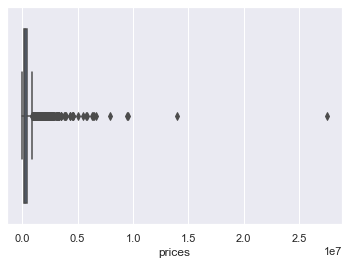

In [213]:
# Generate the boxplot of price.

sns.boxplot(data.prices)

In [214]:
data['prices'].sort_values(ascending=False).head(10)

1123    27500000
1066    13998000
1309     9500000
1030     9495000
904      7883137
960      6645512
1304     6500000
1003     6350000
1183     6250000
898      5886478
Name: prices, dtype: int64

In [215]:
price_drop_idx = data[(data['prices']> 8000000)].index

In [216]:
# Revome the outliers.

data.drop(index=price_drop_idx, inplace=True)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


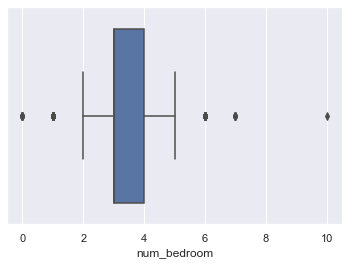

In [217]:
# Generate the boxplot of num_bedroom.

sns.boxplot(data.num_bedroom)

In [218]:
data[(data['num_bedroom'] == 0)]

,address,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_garage,lot_size,home_type,roof,year_built,school_rating,prices
775,"215 S 181st St #4, Elkhorn, NE 68022",https://www.zillow.com/homedetails/215-S-181st...,0.0,2.0,Basement (not specified),Other,Other,3815.0,1.0,0.35,Single Family,Roof(not specified),2020.0,8.0,1294200
1203,"1415 154th Ave NE APT B412, Bellevue, WA 98007",https://www.zillow.com/homedetails/1415-154th-...,0.0,1.0,Basement (not specified),Electric,Central Air,432.0,2.0,0.35,Condo,Other,1977.0,3.0,244000
1217,"1100 106th Ave NE APT 209, Bellevue, WA 98004",https://www.zillow.com/homedetails/1100-106th-...,0.0,1.0,Basement (not specified),Both,Central Air,507.0,1.0,0.99,Condo,Composition,2002.0,7.0,450000
1289,"1085 103rd Ave NE #110, Bellevue, WA 98004",https://www.zillow.com/homedetails/1085-103rd-...,0.0,1.0,Basement (not specified),Other,Central Air,406.0,1.0,0.35,Condo,Flat,2018.0,7.0,425000
1302,"1085 103rd Ave NE #523, Bellevue, WA 98004",https://www.zillow.com/homedetails/1085-103rd-...,0.0,1.0,Basement (not specified),Other,Central Air,528.0,1.0,0.35,Condo,Flat,2018.0,7.0,479000
1892,"1904 52nd St, Des Moines, IA 50310",https://www.zillow.com/homedetails/1904-52nd-S...,0.0,2.0,Partially Finished,Gas,Central Air,1424.0,2.0,0.18,Single Family,Asphalt Shingle,1950.0,3.0,171900
1901,"2709 51st St, Des Moines, IA 50310",https://www.zillow.com/homedetails/2709-51st-S...,0.0,2.0,Partially Finished,Gas,Central Air,1655.0,2.0,0.42,Single Family,Asphalt,1932.0,3.0,205000
1968,"2431 E 36th Ct, Des Moines, IA 50317",https://www.zillow.com/homedetails/2431-E-36th...,0.0,2.0,Basement (not specified),Gas,Central Air,1840.0,2.0,0.19,Single Family,Asphalt,1980.0,2.0,174900
2210,"2415 Garfield Ave, Des Moines, IA 50317",https://www.zillow.com/homedetails/2415-Garfie...,0.0,0.0,Finished,Other,Central Air,910.0,2.0,7013.00,Single Family,Asphalt,1974.0,4.0,74764
2732,"LOT 33 Jordan Lea 149th St, Urbandale, IA 50323",https://www.zillow.com/homedetails/LOT-33-Jord...,0.0,0.0,Basement (not specified),Gas,Central Air,17316.0,0.0,0.40,Single Family,Asphalt,2020.0,8.0,650000


In [219]:
# Change the outliers

median_bedroom = data.num_bedroom.median()
data['num_bedroom'] = data.num_bedroom.apply(lambda x: median_bedroom if x==0 else x)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


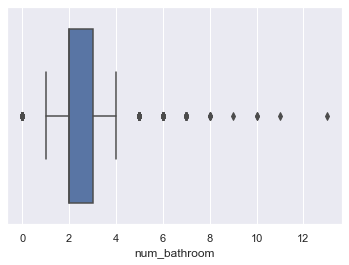

In [220]:
# Generate the boxplot of num_bathroom.

sns.boxplot(data.num_bathroom)

In [221]:
data[(data['num_bathroom'] > 8)]

,address,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_garage,lot_size,home_type,roof,year_built,school_rating,prices
218,"14243 Hamilton St, Omaha, NE 68154",https://www.zillow.com/homedetails/14243-Hamil...,4.0,13.0,Finished,Gas,Central Air,18194.0,5.0,3.73,Single Family,Other,1993.0,7.0,2150000
233,"5505 N 230th St, Elkhorn, NE 68022",https://www.zillow.com/homedetails/5505-N-230t...,5.0,10.0,Finished,Gas,Central Air,10572.0,6.0,13.05,Single Family,Other,2000.0,7.0,3000000
280,"1206 N 136th Ave, Omaha, NE 68154",https://www.zillow.com/homedetails/1206-N-136t...,7.0,10.0,Finished,Gas,Central Air,12279.0,9.0,2.21,Single Family,Composition,2000.0,7.0,2699000
510,"709 S 96th St, Omaha, NE 68114",https://www.zillow.com/homedetails/709-S-96th-...,5.0,9.0,Finished,Gas,Central Air,9262.0,8.0,2.72,Single Family,Composition,1995.0,8.0,2500000
2424,"14851 Highway 6, Gretna, NE 68028",https://www.zillow.com/homedetails/14851-Highw...,10.0,11.0,Finished,Electric,Heat Pump,12217.0,8.0,4.00,Single Family,Composition,1999.0,8.0,850000


In [222]:
# Change the outliers

median_bathroom = data.num_bathroom.median()
data['num_bathroom'] = data.num_bathroom.apply(lambda x: median_bathroom if x==13 else x)

In [223]:
data[(data['num_bathroom'] == 0)]

,address,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_garage,lot_size,home_type,roof,year_built,school_rating,prices
15,"5706 S 114th St, Omaha, NE 68137",https://www.zillow.com/homedetails/5706-S-114t...,3.0,0.0,Finished,Gas,Central Air,1802.0,1.0,8712.00,Single Family,Composition,1970.0,4.0,180000
34,"906 N 149th Ave, Omaha, NE 68154",https://www.zillow.com/homedetails/906-N-149th...,4.0,0.0,Finished,Gas,Central Air,2835.0,2.0,10018.00,Single Family,Shingle,1981.0,8.0,324000
116,"1717 S 33rd St, Omaha, NE 68105",https://www.zillow.com/homedetails/1717-S-33rd...,4.0,0.0,Finished,Gas,Central Air,1818.0,1.0,2613.00,Single Family,Composition,1905.0,1.0,245000
133,"12612 Ohern St, Omaha, NE 68137",https://www.zillow.com/homedetails/12612-Ohern...,3.0,0.0,Finished,Gas,Central Air,1440.0,1.0,7405.00,Single Family,Composition,1964.0,5.0,135000
134,"9668 Ames Ave, Omaha, NE 68134",https://www.zillow.com/homedetails/9668-Ames-A...,3.0,0.0,Finished,Gas,Central Air,1612.0,2.0,8276.00,Single Family,Composition,1970.0,3.0,195000
146,"4123 S 20th St, Omaha, NE 68107",https://www.zillow.com/homedetails/4123-S-20th...,3.0,0.0,Finished,Gas,Central Air,1680.0,2.0,5662.00,Single Family,Composition,1952.0,1.0,139711
159,"5063 Q St, Omaha, NE 68117",https://www.zillow.com/homedetails/5063-Q-St-O...,4.0,0.0,Finished,Gas,Central Air,1976.0,6.0,0.25,Single Family,Composition,1925.0,2.0,207000
193,"716 N 155th St, Omaha, NE 68154",https://www.zillow.com/homedetails/716-N-155th...,4.0,0.0,Finished,Gas,Central Air,2736.0,2.0,7840.00,Single Family,Composition,1986.0,8.0,275000
208,"4443 William St, Omaha, NE 68105",https://www.zillow.com/homedetails/4443-Willia...,3.0,0.0,Finished,Gas,Central Air,1394.0,2.0,7405.00,Single Family,Tile,1926.0,2.0,285000
212,"10424 Nebraska Ave, Omaha, NE 68134",https://www.zillow.com/homedetails/10424-Nebra...,4.0,0.0,Partially Finished,Gas,Central Air,3302.0,3.0,0.25,Single Family,Composition,1993.0,3.0,285000


In [224]:
# Change the outliers

median_bathroom = data.num_bathroom.median()
data['num_bathroom'] = data.num_bathroom.apply(lambda x: median_bathroom if x==0 else x)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


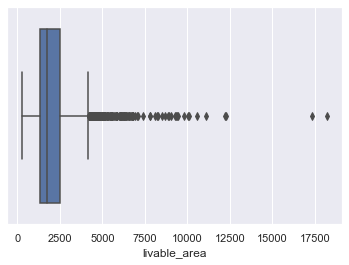

In [225]:
# Generate the boxplot of livable_area.

sns.boxplot(data.livable_area)

In [226]:
data[(data['livable_area'] > 12500)]

,address,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_garage,lot_size,home_type,roof,year_built,school_rating,prices
218,"14243 Hamilton St, Omaha, NE 68154",https://www.zillow.com/homedetails/14243-Hamil...,4.0,2.0,Finished,Gas,Central Air,18194.0,5.0,3.73,Single Family,Other,1993.0,7.0,2150000
2732,"LOT 33 Jordan Lea 149th St, Urbandale, IA 50323",https://www.zillow.com/homedetails/LOT-33-Jord...,3.0,2.0,Basement (not specified),Gas,Central Air,17316.0,0.0,0.40,Single Family,Asphalt,2020.0,8.0,650000


In [227]:
# Change the outliers

median_livable_area = data.livable_area.median()
data['livable_area'] = data.livable_area.apply(lambda x: median_livable_area if x>17000 else x)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


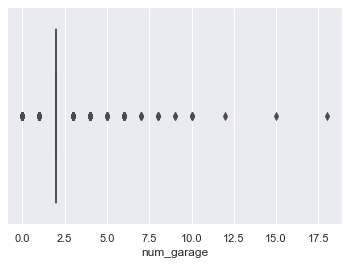

In [228]:
# Generate the boxplot of num_gaeage.

sns.boxplot(data.num_garage)

In [229]:
data.reset_index(drop=True, inplace=True)

In [230]:
data[(data['num_garage'] > 10)]

,address,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_garage,lot_size,home_type,roof,year_built,school_rating,prices
1066,"12210 NE 39th St, Bellevue, WA 98005",https://www.zillow.com/homedetails/12210-NE-39...,4.0,5.0,Unfinished,Both,Central Air,4320.0,18.0,1.05,Single Family,Tile,1969.0,8.0,3195000
1101,"1750 152nd Ave NE APT C302, Bellevue, WA 98007",https://www.zillow.com/homedetails/1750-152nd-...,2.0,2.0,Basement (not specified),Other,Central Air,952.0,12.0,0.35,Condo,Composition,1994.0,3.0,318848
1256,"3445 134th Ave NE, Bellevue, WA 98005",https://www.zillow.com/homedetails/3445-134th-...,4.0,3.0,Basement (not specified),Gas,Central Air,4040.0,15.0,0.41,Single Family,Composition,1982.0,8.0,2333777


In [231]:
# Change the outliers, this is an apartment. 

data['num_garage'].iloc[1101] = 2

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


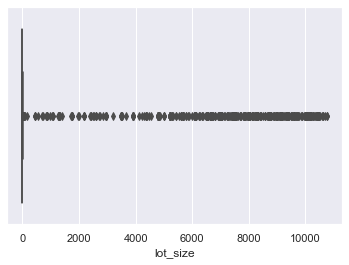

In [232]:
# Generate the boxplot of lot_size.

sns.boxplot(data.lot_size)

In [233]:
# Due to different units, there are many outliers, change to the same unit.

data['lot_size'] = data.lot_size.apply(lambda x: x/43560 if x>100 else x)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


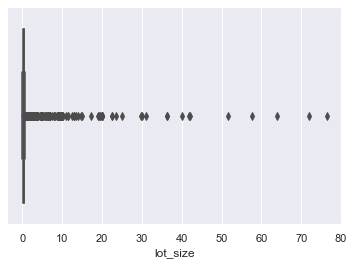

In [234]:
sns.boxplot(data.lot_size)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


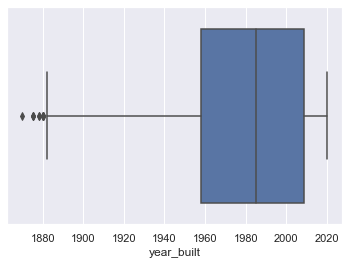

In [235]:
# Generate the boxplot of year_built.

sns.boxplot(data.year_built)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


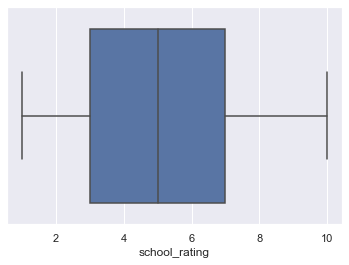

In [236]:
# Generate the boxplot of school_rating.

sns.boxplot(data.school_rating)

In [237]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2850 entries, 0 to 2849
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        2850 non-null   object 
 1   links          2850 non-null   object 
 2   num_bedroom    2850 non-null   float64
 3   num_bathroom   2850 non-null   float64
 4   basement       2850 non-null   object 
 5   heating        2850 non-null   object 
 6   cooling        2850 non-null   object 
 7   livable_area   2850 non-null   float64
 8   num_garage     2850 non-null   float64
 9   lot_size       2850 non-null   float64
 10  home_type      2850 non-null   object 
 11  roof           2850 non-null   object 
 12  year_built     2850 non-null   float64
 13  school_rating  2850 non-null   float64
 14  prices         2850 non-null   int64  
dtypes: float64(7), int64(1), object(7)
memory usage: 334.1+ KB


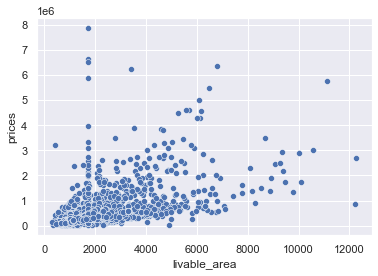

In [238]:
# Scatterplot livable_area and prices

sns.scatterplot(data=data, x='livable_area', y='prices')

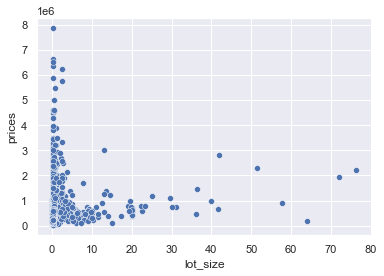

In [239]:
# Scatterplot lot_size and prices

sns.scatterplot(data=data, x='lot_size', y='prices')

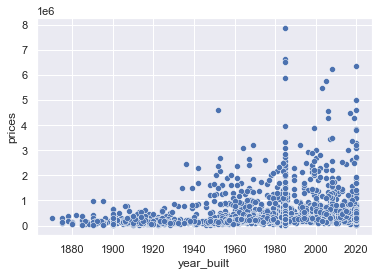

In [240]:
# Scatterplot year_built and prices

sns.scatterplot(data=data, x='year_built', y='prices')

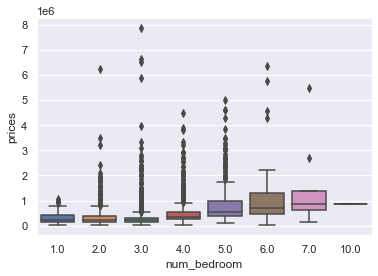

In [241]:
# Box plot num_bedroom and prices

sns.boxplot(x=data['num_bedroom'], y=data['prices'])

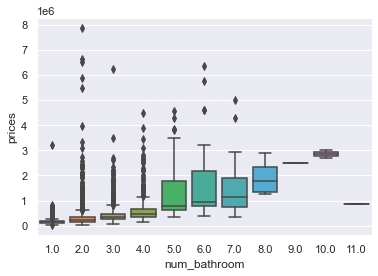

In [242]:
# Box plot num_bathroom and prices

sns.boxplot(x=data['num_bathroom'], y=data['prices'])

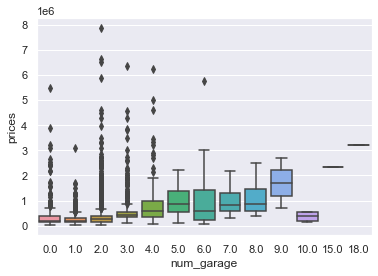

In [243]:
# Box plot num_garage and prices

sns.boxplot(x=data['num_garage'], y=data['prices'])

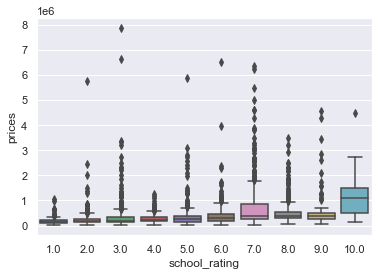

In [244]:
# Box plot school_rating and prices

sns.boxplot(x=data['school_rating'], y=data['prices'])

D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


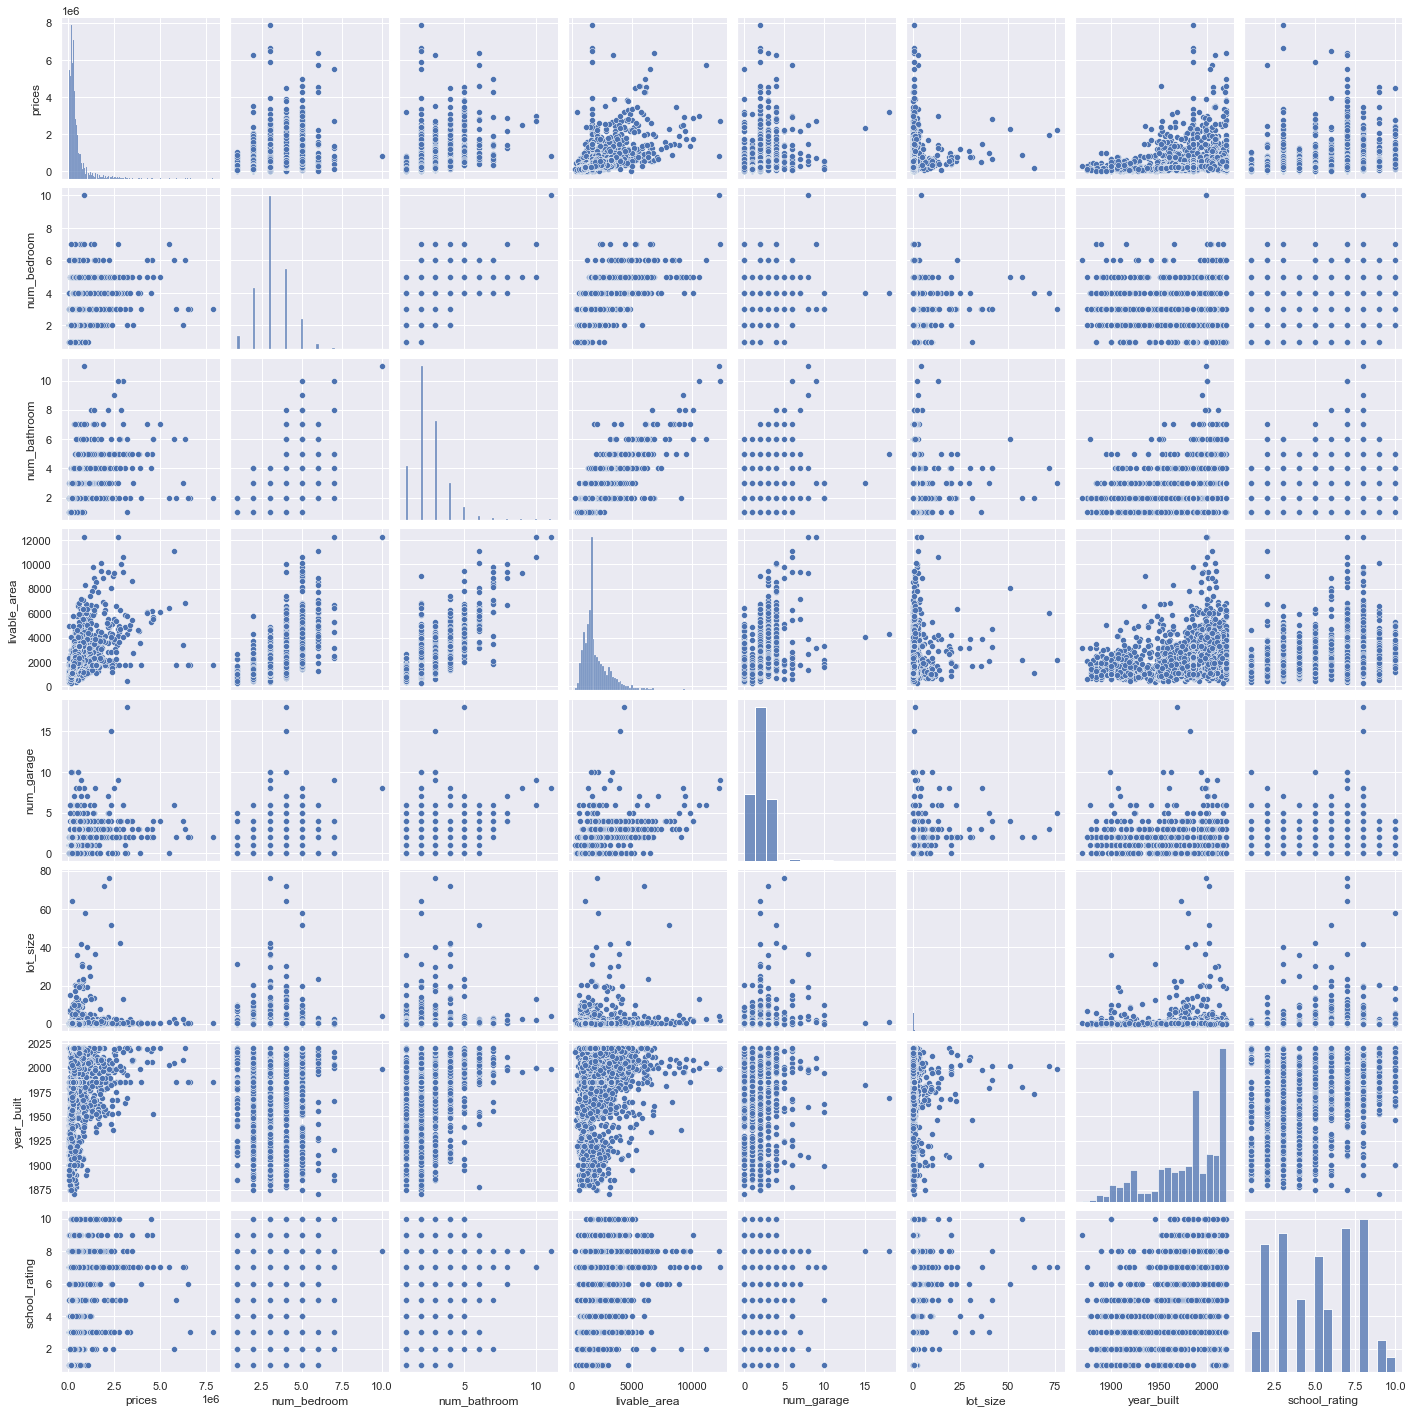

In [245]:
# scatterplot

sns.set()
cols = ['prices', 'num_bedroom', 'num_bathroom', 'livable_area', 'num_garage', 'lot_size', 'year_built', 'school_rating']
sns.pairplot(data[cols], size = 2.5)
plt.show()

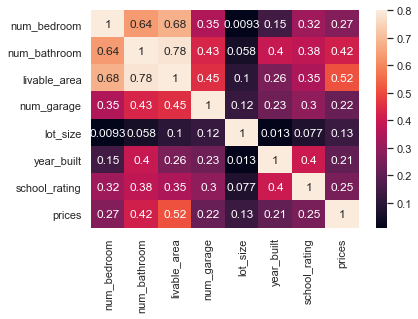

In [246]:
# Correlation plot

corrmat = data.corr()
sns.heatmap(corrmat, vmax=.8, annot=True)

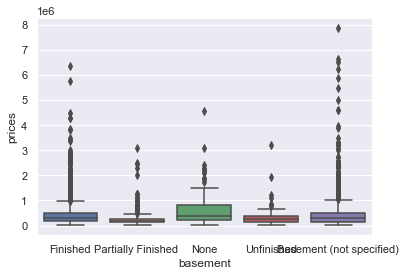

In [247]:
# Box plot basement and prices

sns.boxplot(x=data['basement'], y=data['prices'])

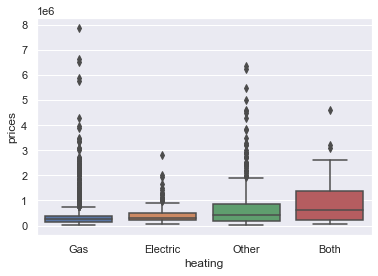

In [248]:
# Box plot heating and prices

sns.boxplot(x=data['heating'], y=data['prices'])

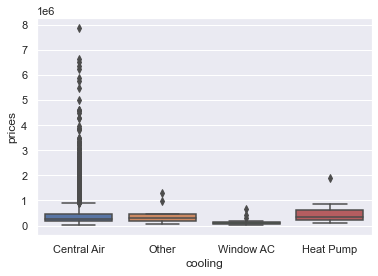

In [249]:
# Box plot cooling and prices

sns.boxplot(x=data['cooling'], y=data['prices'])

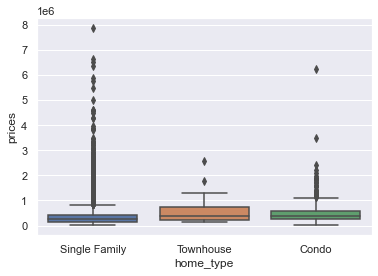

In [250]:
# Box plot home_type and prices

sns.boxplot(x=data['home_type'], y=data['prices'])

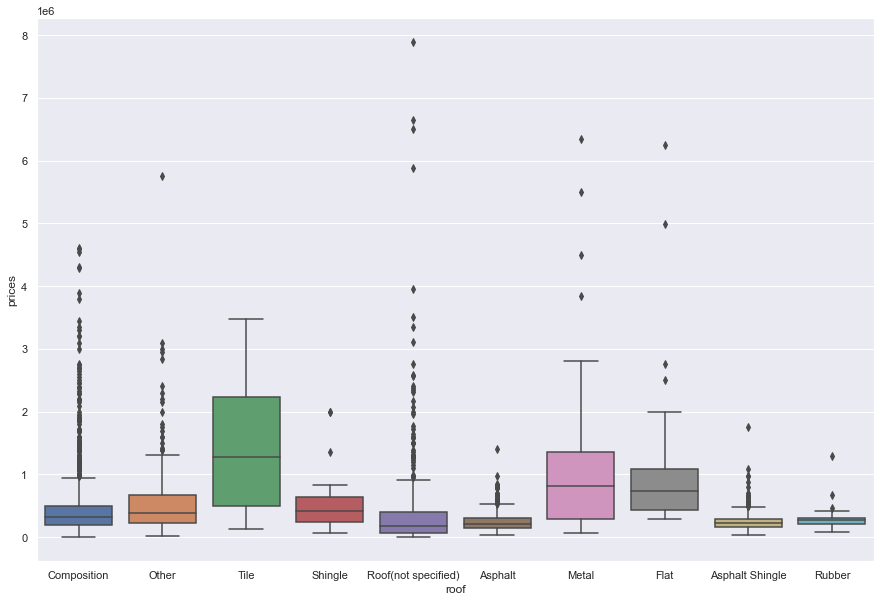

In [251]:
# Box plot roof and prices

plt.figure(figsize=(15,10))
sns.boxplot(x=data['roof'], y=data['prices'])

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


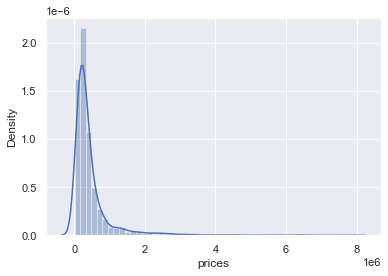

In [252]:
# Generate the histogram of prices

sns.distplot(data['prices'])

In [253]:
data['prices'].skew()

4.90269584113437

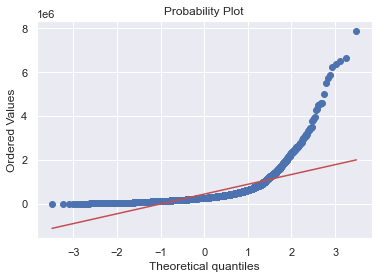

In [82]:
# Generate the normal probability plot

res = stats.probplot(data['prices'], plot=plt)

In [83]:
# Apply log transformation

data['prices'] = np.log(data['prices'])

In [255]:
data.drop(columns=['links', 'address'], inplace=True)

In [105]:
data_dummy = pd.get_dummies(data)

In [106]:
# Train/test split

cols = list(data_dummy.columns)
cols.remove('prices')
X = data_dummy[cols]
y = data_dummy.prices 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [126]:
# Random forest.

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [116]:
# Make predictions using the testing set

rf_predict = rf.predict(X_test)

In [125]:
# Calculate the mean squared error of the data.

mean_squared_error(y_test, rf_predict)

0.2883845626446476

In [129]:
# Linear regression.

regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [130]:
# Make predictions using the testing set

regr_predict = regr.predict(X_test)

In [131]:
# Calculate the mean squared error of the data.

mean_squared_error(y_test, regr_predict)

0.3634164113176274

In [132]:
# Calculate coefficient of determiniation.

r2_score(y_test, regr_predict)

0.556175835326131

In [144]:
# Support vector regression.

svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [145]:
# Make predictions using the testing set

svr_predict = svr.predict(X_test)

In [146]:
# Calculate the mean squared error of the data.

mean_squared_error(y_test, svr_predict)

0.500840167547494

In [150]:
model_predict = model.predict(X_test)

In [152]:
mean_squared_error(y_test, model_predict)

0.5896436118344024

In [173]:
data.to_csv("house_prices.csv")

In [2]:
import pandas as pd
df_test = pd.read_csv('house_prices.csv', index_col=0)
df_test.shape

(2850, 13)